In [111]:
import os
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import MaxNLocator
import numpy as np

def generate_cp(system_name, exp, frac, mappings_dir, log=False, symlog=False, add=False, sub=False, mul=False, div=False, point_size=1):
    if log and symlog:
        print("Error: Cannot use both 'log' and 'symlog' flags simultaneously. Please specify only one scaling method.")
        return

    operator_flags = {"+": add, "-": sub, "*": mul, "/": div}
    
    color_mapping = {
        "Exact": "black",
        "NAR/NAN": "gold",
        "Overflow": "red",
        "Underflow": "red",
        "Approximation": "purple",
        "Saturate": "blue",
    }

    try:
        graphs = {}
        with open(mappings_dir, 'r') as file:
            lines = file.readlines()

        current_operand = None
        data = []

        for line in lines:
            line = line.strip()
            if line.startswith("Generate '"):
                if current_operand and data:
                    graphs[current_operand] = pd.DataFrame(data, columns=["Result", "Value 1", "Operand", "Value 2", "Output", "Float(64) Value", "Value 1 Encoding", "Value 2 Encoding", "Output Encoding", "Absolute Error", "Relative Error", "Normalized Relative Log Error"])
                current_operand = line.split("'")[1]
                if not operator_flags.get(current_operand, False):
                    current_operand = None
                    continue
                data = []
                continue
            
            if not line or "Result" in line:
                continue

            parts = line.split(',')
            if len(parts) != 12:
                continue
            data.append(parts)

        if current_operand and data:
            graphs[current_operand] = pd.DataFrame(data, columns=["Result", "Value 1", "Operand", "Value 2", "Output", "Float(64) Value", "Value 1 Encoding", "Value 2 Encoding", "Output Encoding", "Absolute Error", "Relative Error", "Normalized Relative Log Error"])
        
        for operand, df in graphs.items():
            if not operator_flags[operand]:  
                continue

            df["Value 1"] = pd.to_numeric(df["Value 1"], errors="coerce")
            df["Value 2"] = pd.to_numeric(df["Value 2"], errors="coerce") 

            # Skip entries where Value 1 or Value 2 is inf
            df = df[~np.isinf(df["Value 1"]) & ~np.isinf(df["Value 2"])]
            df = df.dropna(subset=["Value 1", "Value 2"]) 
            colors = df["Result"].map(color_mapping)
            assert colors is not None, "Bin not found."

            plt.figure(figsize=(6, 6))
            plt.scatter(df["Value 1"], df["Value 2"], c=colors, s=point_size)

            # Set custom ticks: min, 0, max
            x_min, x_max = df["Value 1"].min(), df["Value 1"].max()
            x_ticks = [x_min, 0, x_max]
            plt.xticks(x_ticks)

            y_min, y_max = df["Value 2"].min(), df["Value 2"].max()
            y_ticks = [y_min, 0, y_max]
            plt.yticks(y_ticks)

            plt.xlabel("Value 1")
            plt.ylabel("Value 2")
            plt.title(f"Operation: {operand}")
            plt.figtext(0.5, 0.01, system_name, ha="center", fontsize=10)
            
            if log:
                plt.xscale("log")
                plt.yscale("log")
            elif symlog:
                linthresh = 1e-3  # Adjust based on your data
                plt.xscale("symlog", linthresh=linthresh)
                plt.yscale("symlog", linthresh=linthresh)

            # Ensure only min, 0, and max ticks show by applying a MaxNLocator for both axes
            plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, prune='both', steps=[1, 2, 3]))
            plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True, prune='both', steps=[1, 2, 3]))

            plt.tight_layout(rect=[0, 0.1, 1, 1])
            plt.show()

    except FileNotFoundError:
        print(f"Error: Could not find file at: {mappings_dir}")
    except Exception as e:
        print(f"Error: {e}")


In [114]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.colors as mcolors

def generate_grad_cp_4(system_name, exp, frac, mappings_dir, add=False, sub=False, mul=False, div=False, point_size=1, error_type="RelLog"):
    operator_flags = {"+": add, "-": sub, "*": mul, "/": div}
    red_cmap = mcolors.LinearSegmentedColormap.from_list(
        "my_reds", ["#FFCCCC", "#FF6666", "#FF0000", "#8B0000"], N=256
    )
    num_bits = exp + frac

    # Map error_type to column name
    error_types = {"Abs": "Absolute Error", "Rel": "Relative Error", "RelLog": "Normalized Relative Log Error"}
    if error_type not in error_types:
        raise ValueError(f"error_type must be one of {list(error_types.keys())}, got {error_type}")
    error_column = error_types[error_type]

    def bin_to_int(binary_string):
        return int(binary_string, 2)

    graphs = {}
    with open(mappings_dir, 'r') as file:
        lines = file.readlines()

    current_operand = None
    data = []

    for line in lines:
        line = line.strip()
        if line.startswith("Generate '"):
            if current_operand and data:
                graphs[current_operand] = pd.DataFrame(
                    data,
                    columns=["Result", "Value 1", "Operand", "Value 2", "Output", "Float(64) Value",
                             "Value 1 Encoding", "Value 2 Encoding", "Output Encoding",
                             "Absolute Error", "Relative Error", "Normalized Relative Log Error"]
                )
            current_operand = line.split("'")[1]
            if not operator_flags.get(current_operand, False):
                current_operand = None
                continue
            data = []
            continue

        if not line or "Result" in line:
            continue

        parts = line.split(',')
        if len(parts) != 12:
            continue

        data.append(parts)

    if current_operand and data:
        graphs[current_operand] = pd.DataFrame(
            data,
            columns=["Result", "Value 1", "Operand", "Value 2", "Output", "Float(64) Value",
                     "Value 1 Encoding", "Value 2 Encoding", "Output Encoding",
                     "Absolute Error", "Relative Error", "Normalized Relative Log Error"]
        )

    for operand, df in graphs.items():
        if not operator_flags[operand]:
            continue

        df["Value 1"] = pd.to_numeric(df["Value 1"], errors="coerce")
        df["Value 2"] = pd.to_numeric(df["Value 2"], errors="coerce")
        df[error_column] = pd.to_numeric(df[error_column], errors="coerce")

        df['Value 1 Encoding Int'] = df['Value 1 Encoding'].apply(bin_to_int)
        df['Value 2 Encoding Int'] = df['Value 2 Encoding'].apply(bin_to_int)

        df_sorted = df.sort_values(by=['Value 2 Encoding Int', 'Value 1 Encoding Int'])

        x_coords = df_sorted['Value 1 Encoding Int'].values
        y_coords = df_sorted['Value 2 Encoding Int'].values
        error_values = df_sorted[error_column].values
        result_values = df_sorted["Result"].values

        colors = np.empty(len(error_values), dtype=object)
        min_log_err = np.nanmin(error_values)
        max_log_err = np.nanmax(error_values)

        if np.isnan(max_log_err) or max_log_err == 0:
            print(f"Warning: Invalid max_log_err ({max_log_err}) for {system_name}, {operand}. All errors may be NaN or zero.")
            colors[:] = 'black'
        else:
            for i, (err, result) in enumerate(zip(error_values, result_values)):
                if np.isnan(err):
                    colors[i] = 'black'
                elif np.isinf(err) or result in ["Overflow", "Underflow"]:
                    colors[i] = 'purple'
                elif float(err) == 0:
                    colors[i] = 'green'
                else:
                    assert float(err) > 0, f"{error_column} must be >0, got {err}"
                    colors[i] = red_cmap(err / max_log_err)  # Scale to [0, 1] for colormap

        fig, ax = plt.subplots(figsize=(8, 8))
        scatter = ax.scatter(x_coords, y_coords, c=colors, s=point_size)

        ax.set_xlabel("Value 1 Encoding")
        ax.set_ylabel("Value 2 Encoding")
        ax.set_title(f"{system_name}: {operand} Closure Plot with Gradients", ha="center")
        # fig.text(0.5, 0.01, f"{system_name}", ha="center", fontsize=10)

        x_encodings_unique = sorted(df_sorted["Value 1 Encoding"].unique().tolist())
        y_encodings_unique = sorted(df_sorted["Value 2 Encoding"].unique().tolist())

        if x_encodings_unique:
            min_x_int = bin_to_int(x_encodings_unique[0])
            max_x_int = bin_to_int(x_encodings_unique[-1])
            ax.set_xticks([min_x_int, max_x_int])
            ax.set_xticklabels([x_encodings_unique[0], x_encodings_unique[-1]], rotation='vertical', fontsize='small')

        if y_encodings_unique:
            min_y_int = bin_to_int(y_encodings_unique[0])
            max_y_int = bin_to_int(y_encodings_unique[-1])
            ax.set_yticks([min_y_int, max_y_int])
            ax.set_yticklabels([y_encodings_unique[0], y_encodings_unique[-1]], fontsize='small')

        ax.set_xlim(min(x_coords) - 0.5, max(x_coords) + 0.5)
        ax.set_ylim(min(y_coords) - 0.5, max(y_coords) + 0.5)

        handles = [
            plt.Rectangle((0, 0), 1, 1, color='black'),
            plt.Rectangle((0, 0), 1, 1, color='green'),
            plt.Rectangle((0, 0), 1, 1, color='#800080'),
            plt.Rectangle((0, 0), 1, 1, color=red_cmap(0.5)),  # Medium red as representative
        ]
        labels = [
            'NaN/Nar Encoding',
            'Exact Encoding',
            'Overflow/Underflow',
            'Inaccurate Encoding',
        ]
        fig.legend(handles, labels, title=None, loc='lower right', bbox_to_anchor=(0.95, 0), bbox_transform=fig.transFigure, fontsize='small')

        plt.tight_layout(rect=[0, 0.03, 1, 0.92])
        # plt.savefig(f'{system_name}_e{exp}f{frac}_{operand}_scatter.png')
        # plt.close()

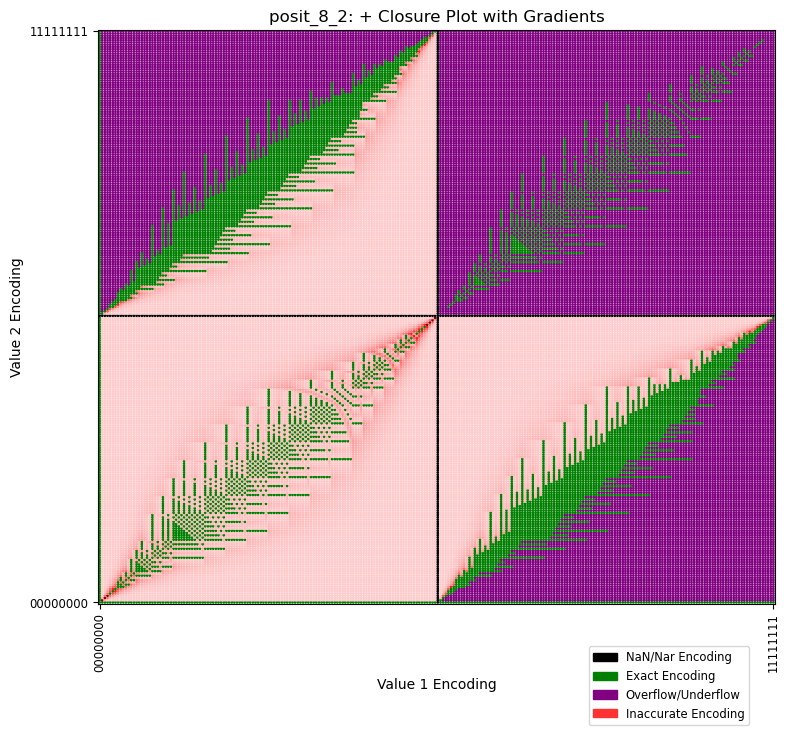

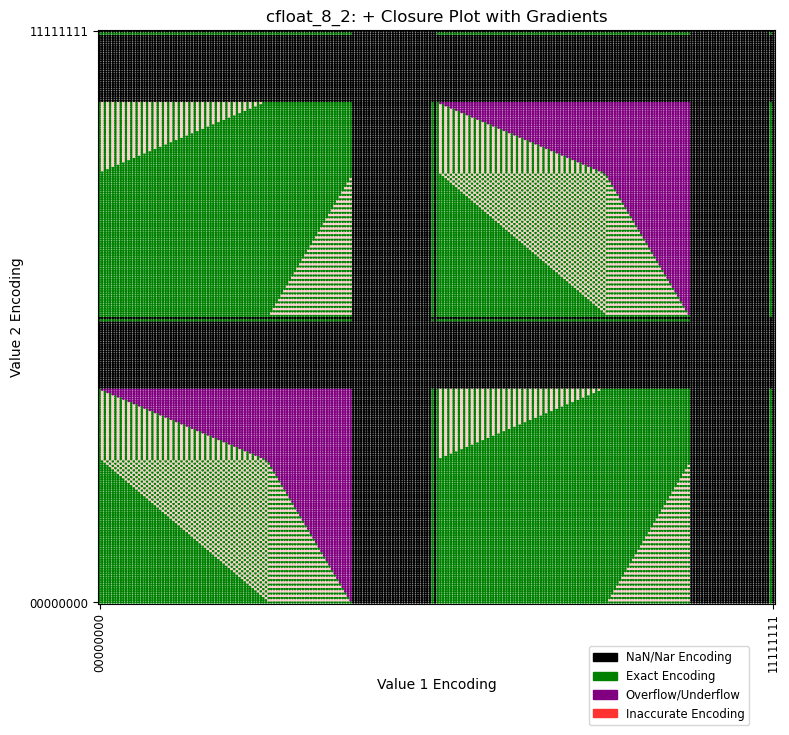

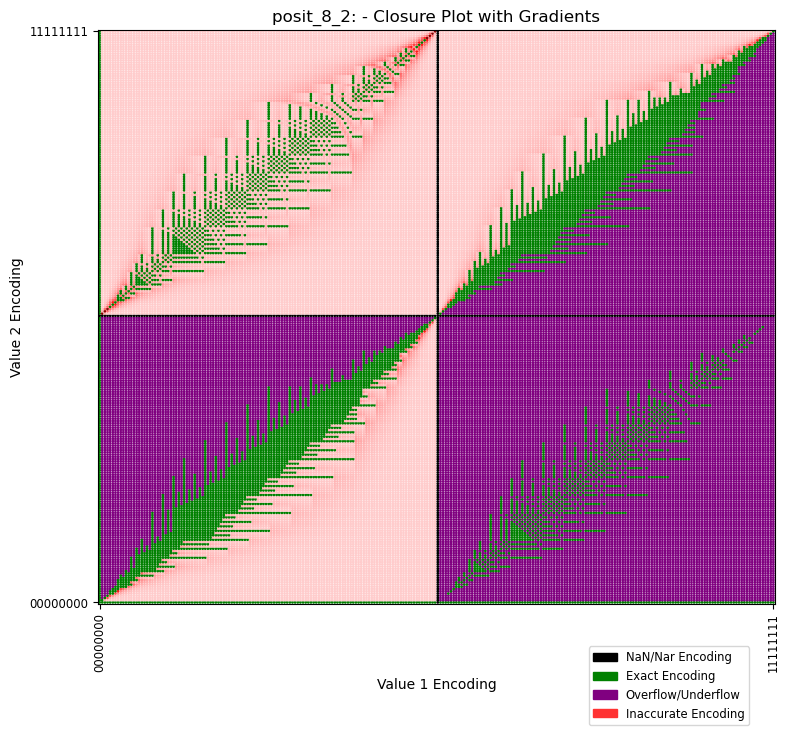

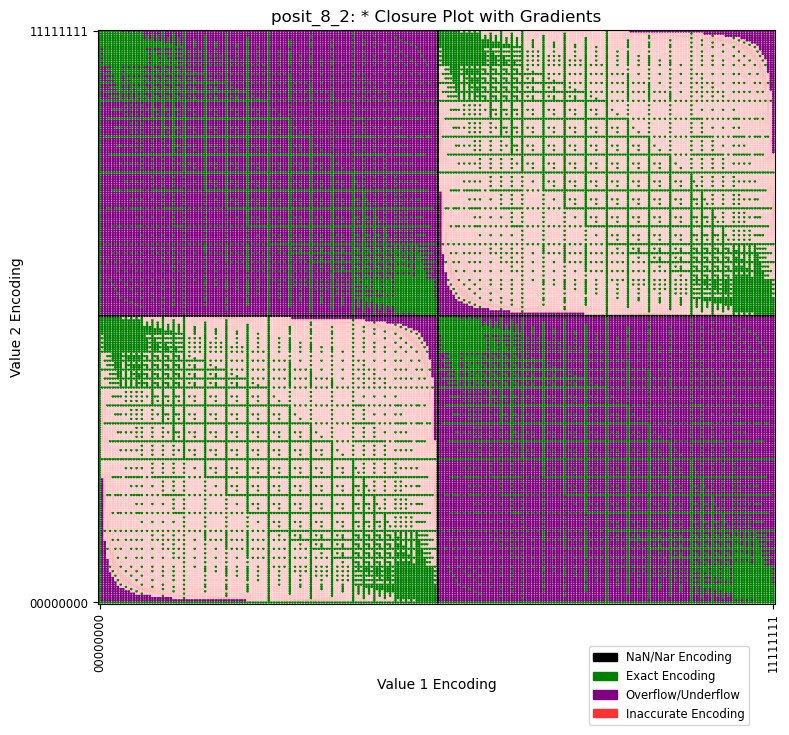

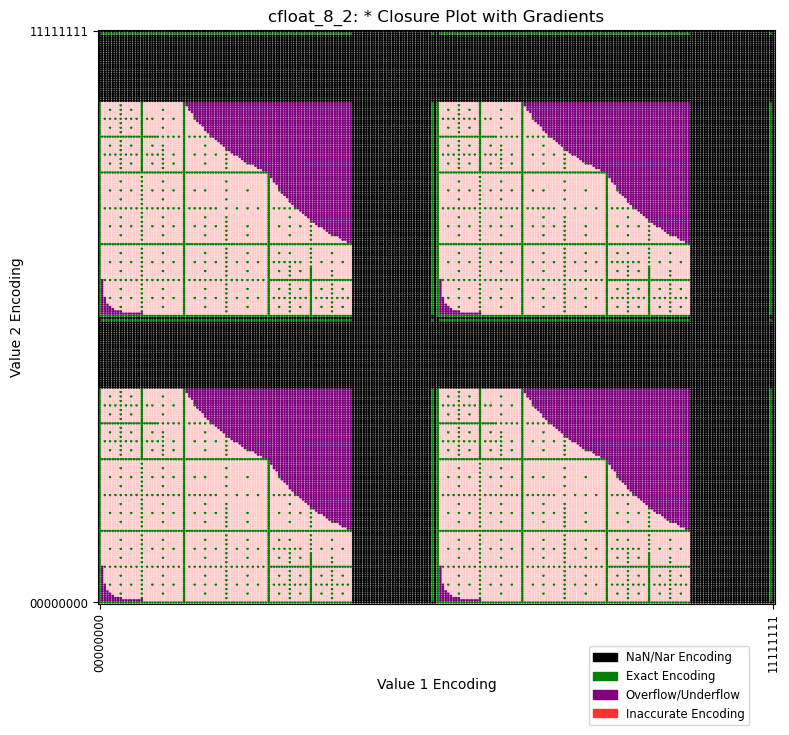

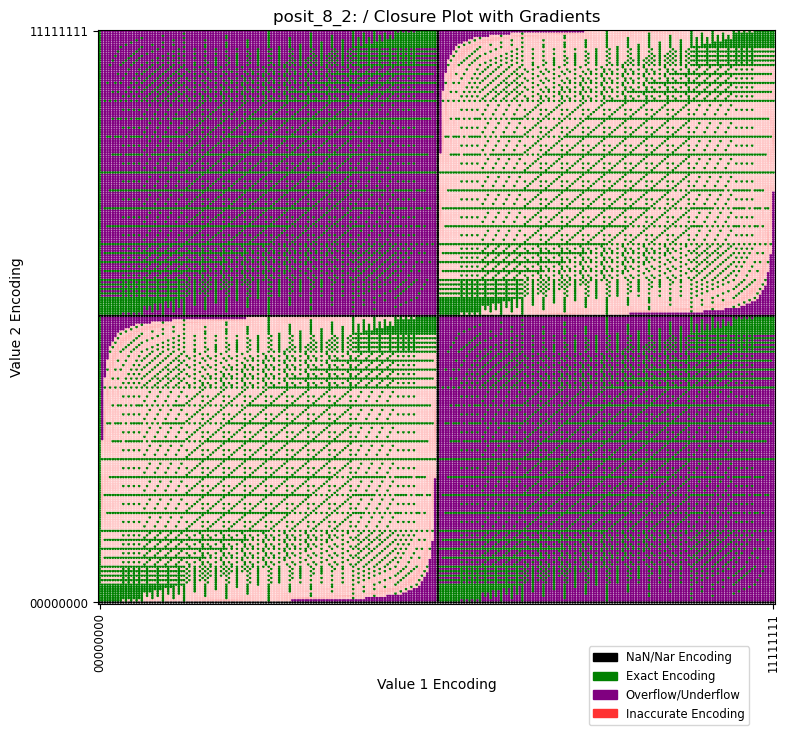

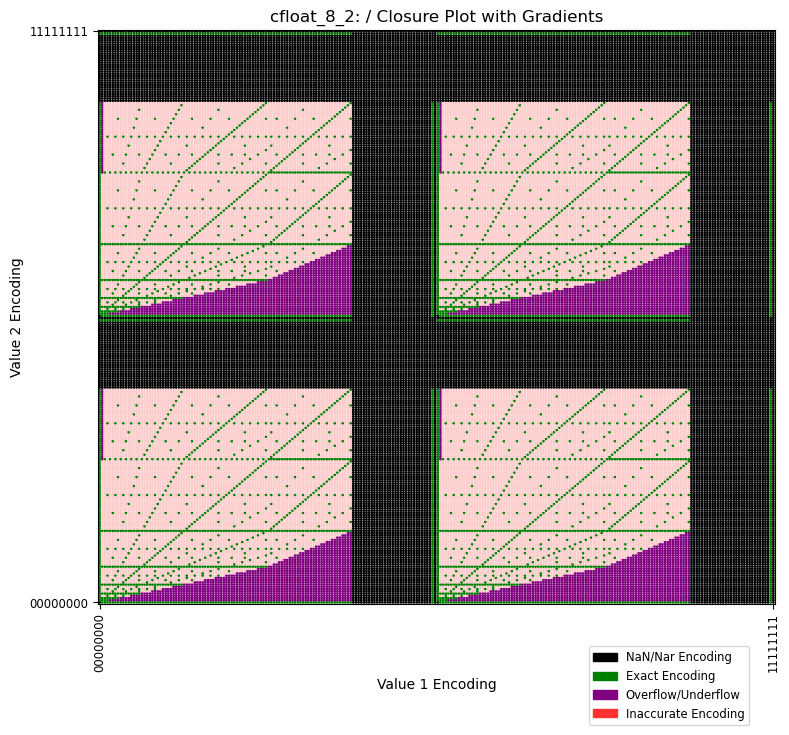

In [115]:
POINT_SIZE = 1
work_dir = os.getenv("WORK_DIR")

# valid_error_types, "Abs": "Absolute Error", "Rel": "Relative Error", "RelLog": "Normalized Relative Log Error"
err="RelLog"

EXP = 8
FRAC = 2
system_name_1 = f"posit_{EXP}_{FRAC}"
system_name_2 = f"cfloat_{EXP}_{FRAC}"

file_dir = os.path.join(work_dir, "build", "mappings")
MAPPINGS_DIR_1 = os.path.join(file_dir, f"{system_name_1}.csv")
MAPPINGS_DIR_2 = os.path.join(file_dir, f"{system_name_2}.csv")

generate_grad_cp_4(system_name=system_name_1, exp=EXP, frac=FRAC, mappings_dir=MAPPINGS_DIR_1, add=True, point_size=POINT_SIZE, error_type=err)
generate_grad_cp_4(system_name=system_name_2, exp=EXP, frac=FRAC, mappings_dir=MAPPINGS_DIR_2, add=True, point_size=POINT_SIZE, error_type=err)
generate_grad_cp_4(system_name=system_name_1, exp=EXP, frac=FRAC, mappings_dir=MAPPINGS_DIR_1, sub=True, point_size=POINT_SIZE, error_type=err)
generate_grad_cp_4(system_name=system_name_1, exp=EXP, frac=FRAC, mappings_dir=MAPPINGS_DIR_1, mul=True, point_size=POINT_SIZE, error_type=err)
generate_grad_cp_4(system_name=system_name_2, exp=EXP, frac=FRAC, mappings_dir=MAPPINGS_DIR_2, mul=True, point_size=POINT_SIZE, error_type=err)
generate_grad_cp_4(system_name=system_name_1, exp=EXP, frac=FRAC, mappings_dir=MAPPINGS_DIR_1, div=True, point_size=POINT_SIZE, error_type=err)
generate_grad_cp_4(system_name=system_name_2, exp=EXP, frac=FRAC, mappings_dir=MAPPINGS_DIR_2, div=True, point_size=POINT_SIZE, error_type=err)

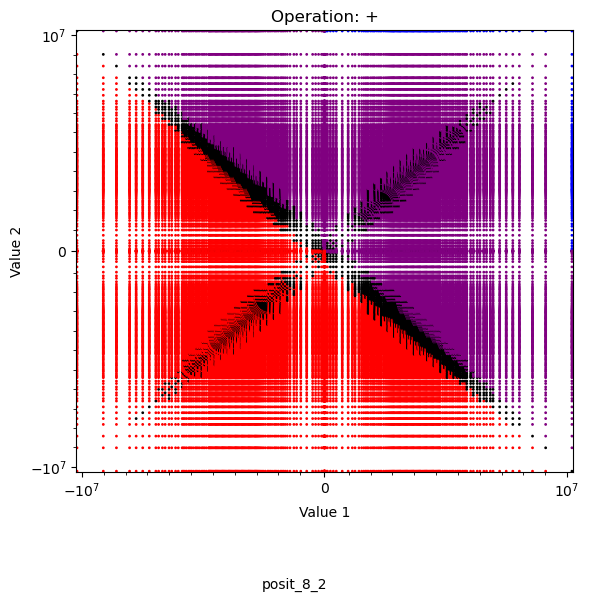

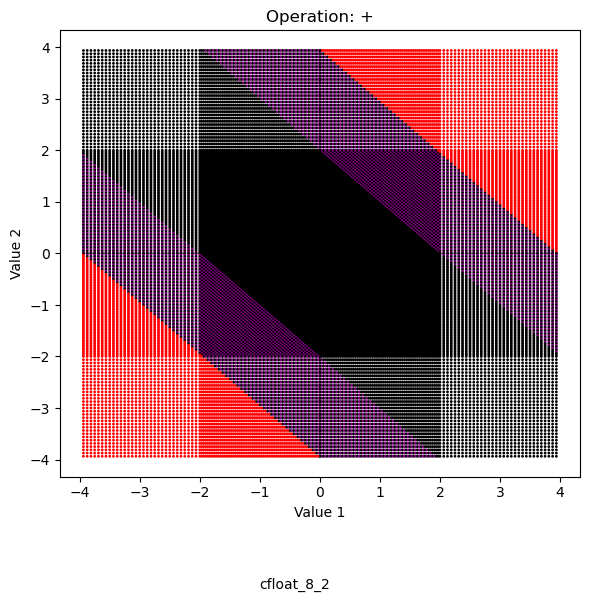

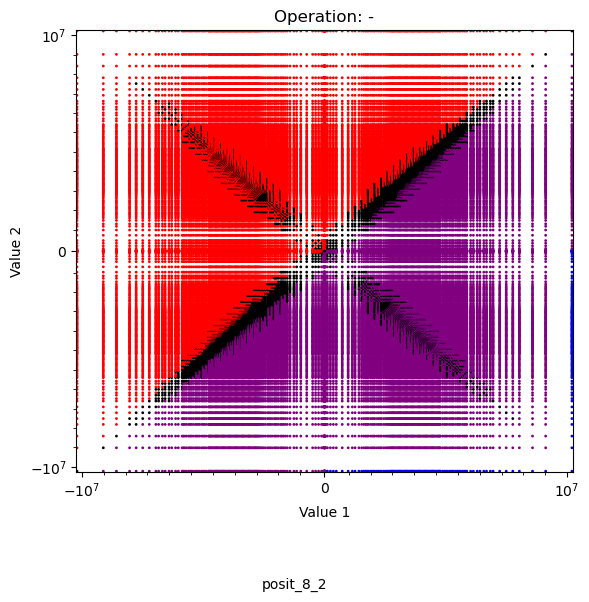

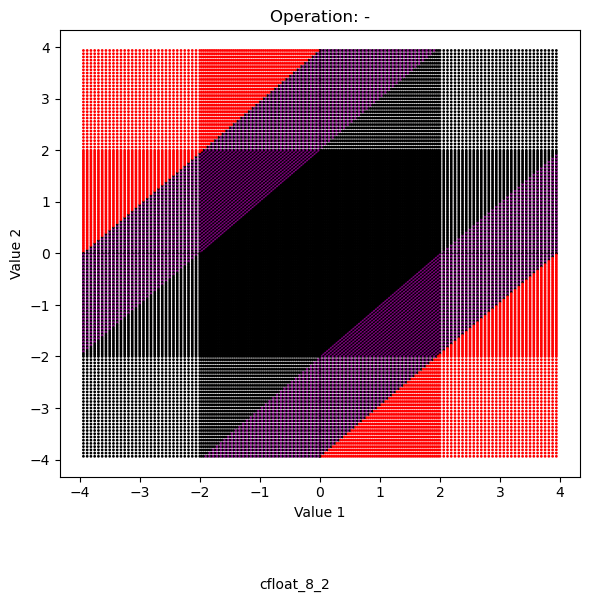

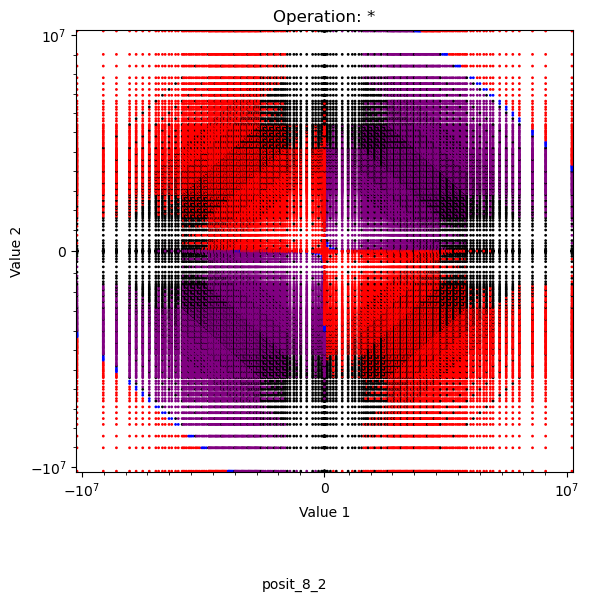

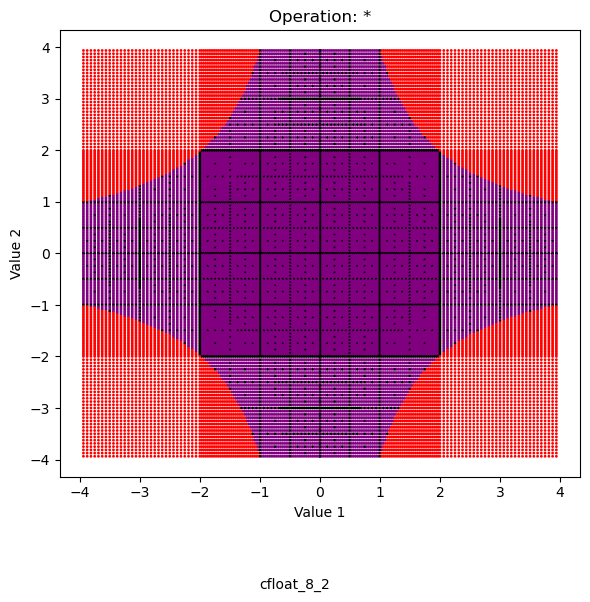

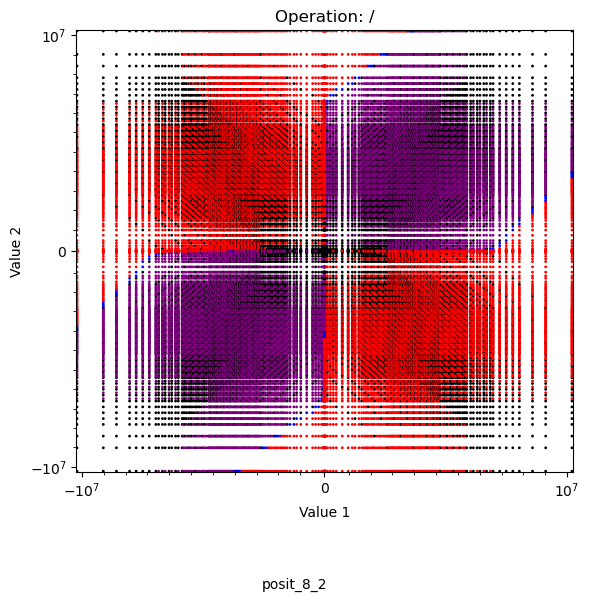

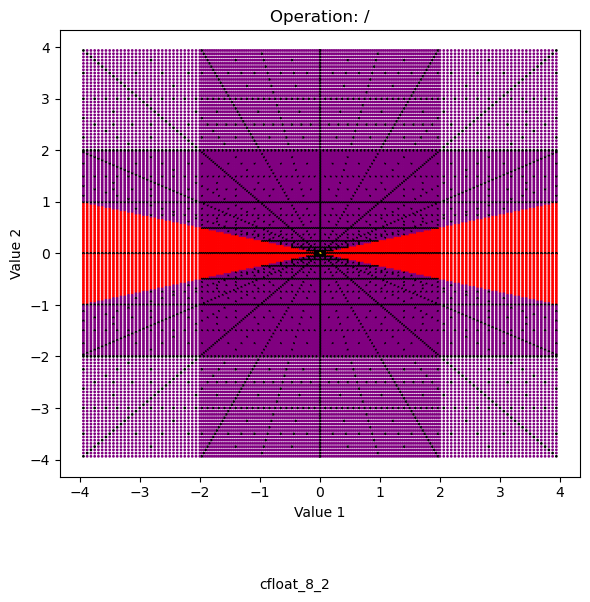

In [77]:
"""
    "Exact": "black",
    "NAR/NAN": "gold",
    "Overflow": "red",
    "Underflow": "red",
    "Approximation": "purple",
    "Saturate": "blue",
"""        

POINT_SIZE = 1
work_dir = os.getenv("WORK_DIR")

EXP = 8
FRAC = 2
system_name_1 = f"posit_{EXP}_{FRAC}"
system_name_2 = f"cfloat_{EXP}_{FRAC}"

file_dir = os.path.join(work_dir, "build", "mappings")
MAPPINGS_DIR_1 = os.path.join(file_dir, f"{system_name_1}.csv")
MAPPINGS_DIR_2 = os.path.join(file_dir, f"{system_name_2}.csv")

generate_cp(system_name=system_name_1, exp=EXP, frac=FRAC, mappings_dir=MAPPINGS_DIR_1, add=True, symlog=True, point_size=POINT_SIZE)
generate_cp(system_name=system_name_2, exp=EXP, frac=FRAC, mappings_dir=MAPPINGS_DIR_2, add=True, symlog=False, point_size=POINT_SIZE)
generate_cp(system_name=system_name_1, exp=EXP, frac=FRAC, mappings_dir=MAPPINGS_DIR_1, sub=True, symlog=True, point_size=POINT_SIZE)
generate_cp(system_name=system_name_2, exp=EXP, frac=FRAC, mappings_dir=MAPPINGS_DIR_2, sub=True, symlog=False, point_size=POINT_SIZE)
generate_cp(system_name=system_name_1, exp=EXP, frac=FRAC, mappings_dir=MAPPINGS_DIR_1, mul=True, symlog=True, point_size=POINT_SIZE)
generate_cp(system_name=system_name_2, exp=EXP, frac=FRAC, mappings_dir=MAPPINGS_DIR_2, mul=True, symlog=False, point_size=POINT_SIZE)
generate_cp(system_name=system_name_1, exp=EXP, frac=FRAC, mappings_dir=MAPPINGS_DIR_1, div=True, symlog=True, point_size=POINT_SIZE)
generate_cp(system_name=system_name_2, exp=EXP, frac=FRAC, mappings_dir=MAPPINGS_DIR_2, div=True, symlog=False, point_size=POINT_SIZE)

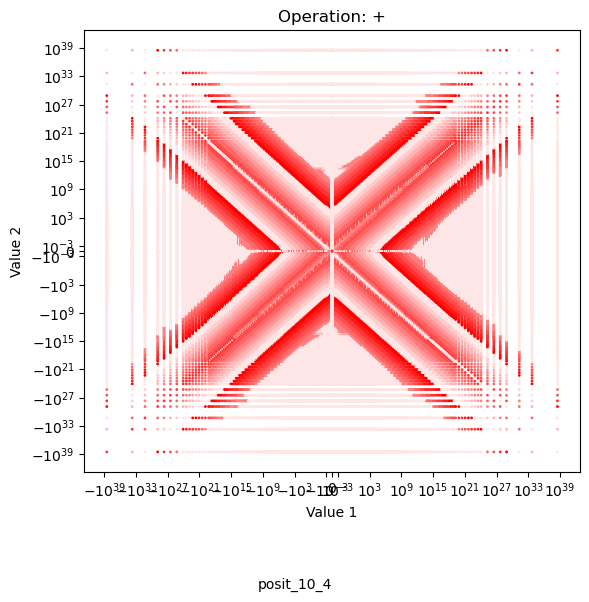

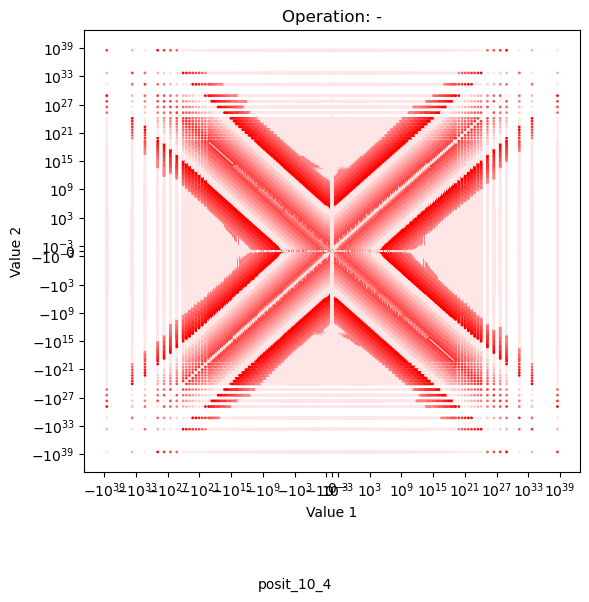

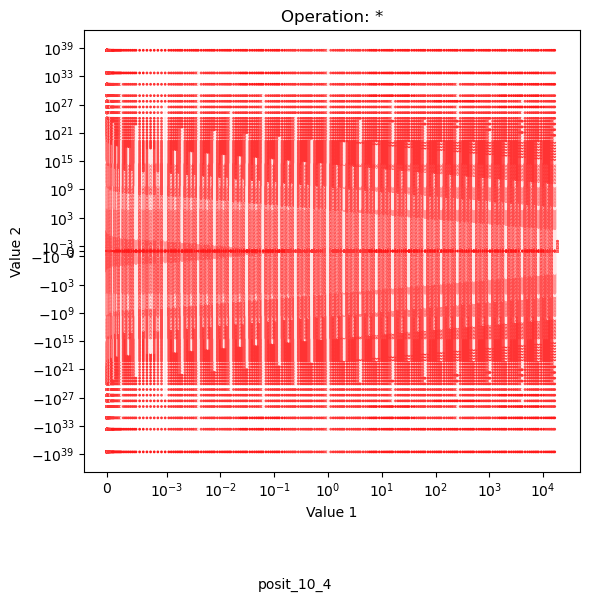

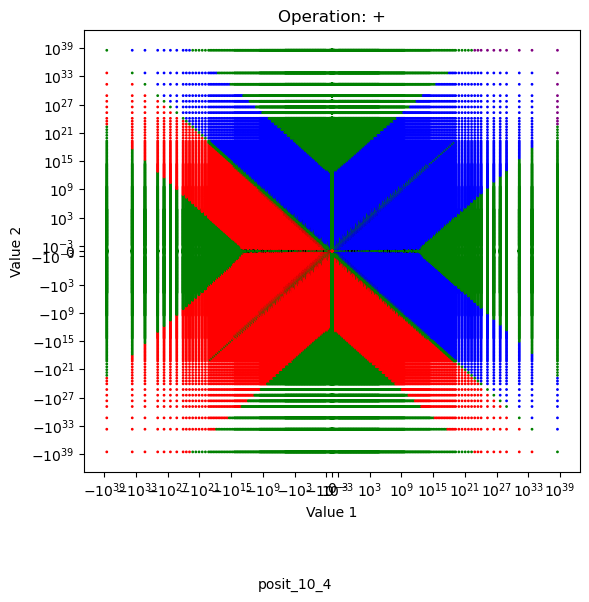

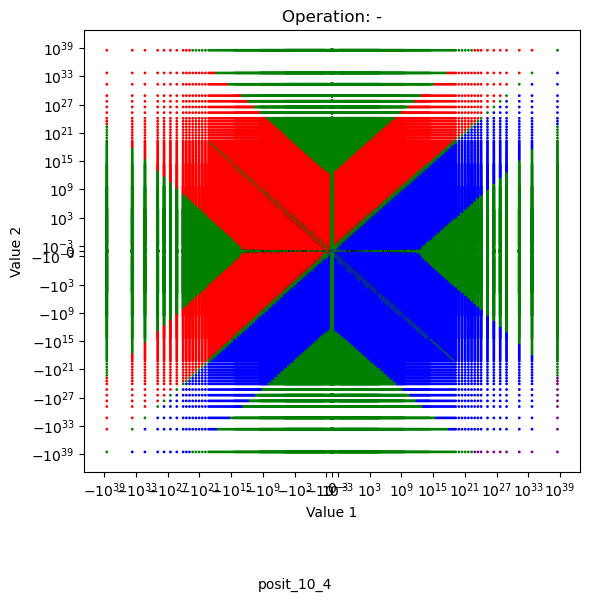

KeyboardInterrupt: 

In [ ]:
"""


Key for grad_cp:
Darker Reds are closer to 1 (higher error)
Lighter Reds are closer to 0, (less Error)


Key For bin_cp:

"Exact": "green",
"NAR": "black",
"Overflow": "red",
"Underflow": "red",
"Approximation": "blue",
"Saturate" : "purple",
"Unknown": "pink" - This should not happen.

"""        

assert 1==2, "dont update these visuals below"


EXP = 10
FRAC = 4

ADD=True
SUB=False
MUL=False
DIV=False

POINT_SIZE = 1
LOG = False
SYMLOG = True
LOG_BINS = True

system_name = f"posit_{EXP}_{FRAC}"
file_dir = "/Users/colby/universal/build/mappings/"
mappings_dir = os.path.join(file_dir, f"{system_name}.csv")


# errorMapperByBin(system_name, EXP, FRAC, mappings_dir, point_size=POINT_SIZE, log=LOG, symlog = SYMLOG, add=ADD, sub=SUB, mul=MUL, div=DIV)
generate_grad_cp(system_name, EXP, FRAC, mappings_dir, point_size=POINT_SIZE, log=LOG, symlog = SYMLOG, add=ADD, sub=SUB, mul=MUL, div=DIV, log_bins=LOG_BINS)
generate_bin_cp(system_name, EXP, FRAC, mappings_dir, point_size=POINT_SIZE, log=LOG, symlog = SYMLOG, add=ADD, sub=SUB, mul=MUL, div=DIV)